In [1]:
import pandas as pd
import re
import requests
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn import metrics
import catboost
import lightgbm


plt.rcParams['figure.figsize'] = [40, 40]
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

**Load datasets and preprocessing information with adding new features.**
**Create train and validation set for models**

In [3]:
# Loading data for countries and removing unnecesary columns
countries = pd.read_csv("./datasets/countries.csv")
countries.drop(['iso_alpha2', 'iso_numeric', 'name', 'official_name'], axis='columns', inplace=True)

In [4]:
"""Loading data for confirmed cases. Grouping data by country, ignoring province.
Delete latitude and longtitude columns.
Each date must be on a single row.
"""


data_confirmed = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data_confirmed = data_confirmed.groupby('Country/Region').sum()
data_confirmed.drop(['Lat', 'Long'], axis='columns', inplace=True)
data_confirmed = data_confirmed.iloc[:, 4:].stack().reset_index()
data_confirmed.columns = ['ccse_name', 'date', 'confirmed']
data_confirmed

,ccse_name,date,confirmed
0,Afghanistan,1/26/20,0
1,Afghanistan,1/27/20,0
2,Afghanistan,1/28/20,0
3,Afghanistan,1/29/20,0
4,Afghanistan,1/30/20,0
...,...,...,...
13243,Zimbabwe,4/2/20,9
13244,Zimbabwe,4/3/20,9
13245,Zimbabwe,4/4/20,9
13246,Zimbabwe,4/5/20,9


In [5]:
"""Loading data for deaths. Grouping data by country, ignoring province.
Delete latitude and longtitude columns.
Each date must be on a single row.
"""


data_deaths = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby('Country/Region').sum()
data_deaths.drop(['Lat', 'Long'], axis='columns', inplace=True)
data_deaths = data_deaths.iloc[:, 4:].stack().reset_index()
data_deaths.columns = ['ccse_name', 'date', 'deaths']
data_deaths

,ccse_name,date,deaths
0,Afghanistan,1/26/20,0
1,Afghanistan,1/27/20,0
2,Afghanistan,1/28/20,0
3,Afghanistan,1/29/20,0
4,Afghanistan,1/30/20,0
...,...,...,...
13243,Zimbabwe,4/2/20,1
13244,Zimbabwe,4/3/20,1
13245,Zimbabwe,4/4/20,1
13246,Zimbabwe,4/5/20,1


In [6]:
""" Loading data for quarantines and grouping them by country,
ignoring region level
"""


quarantines = pd.read_csv("./datasets/quarantine_dates.csv")
quarantines_proccessed = quarantines.groupby('Country').max().reset_index()
quarantines_proccessed.drop(['Place', 'Level'], axis='columns', inplace=True)

In [7]:
"""Merging all info for confirmed cases and deaths with country's info
Casting date to datetime datatype
Delete rows with confirmed == 0
"""


data_all = countries.merge(data_confirmed, how='left', 
                           left_on='ccse_name', right_on='ccse_name')
data_all = data_all.merge(data_deaths, how='left',
                          left_on=('ccse_name', 'date'), right_on=('ccse_name', 'date'))
data_all['date'] = pd.to_datetime(data_all.date)
data_all = data_all[data_all.confirmed != 0]
data_all

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,date,confirmed,deaths
29,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-24,1,0
30,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-25,1,0
31,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-26,1,0
32,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-27,1,0
33,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-28,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12163,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-02,39,1
12164,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-03,39,1
12165,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-04,39,1
12166,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-05,39,1


In [8]:
""" Add new feature - days from first confirmed case
First create dataframe with first day of confirmed case
"""


data_all_2 = data_all[(data_all.date < pd.to_datetime("2020-05-01")) & 
                      (data_all.date > pd.to_datetime("2020-01-01")) | (data_all.confirmed != -1)]
data_days = data_all_2[["ccse_name", "date"]].groupby("ccse_name").min()
data_days.columns = ["date_first_confirmed"]

In [9]:
"""Merge dataframes and count days from first confirmed
"""


data_all_2 = data_all_2.merge(data_days, how='left',
                              left_on='ccse_name', right_on='ccse_name')
data_all_2["date_first_confirmed"] = (data_all_2.date - data_all_2.date_first_confirmed).dt.days
data_all_2

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,date,confirmed,deaths,date_first_confirmed
0,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-24,1,0,0
1,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-25,1,0,1
2,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-26,1,0,2
3,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-27,1,0,3
4,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-28,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6080,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-02,39,1,15
6081,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-03,39,1,16
6082,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-04,39,1,17
6083,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-05,39,1,18


In [10]:
"""Extracting number of confirmed cases and deaths
from previous day
"""


prev_day_confirmed = data_all_2['confirmed'].iloc[:-1]
prev_day_deaths = data_all_2['deaths'].iloc[:-1]
temp_data = data_all_2[['ccse_name', 'date']].iloc[1:]
temp_data["prev_day_confirmed"] = prev_day_confirmed.values
temp_data["prev_day_deaths"] = prev_day_deaths.values

temp_data

,ccse_name,date,prev_day_confirmed,prev_day_deaths
1,Afghanistan,2020-02-25,1,0
2,Afghanistan,2020-02-26,1,0
3,Afghanistan,2020-02-27,1,0
4,Afghanistan,2020-02-28,1,0
5,Afghanistan,2020-02-29,1,0
...,...,...,...,...
6080,Zambia,2020-04-02,36,0
6081,Zambia,2020-04-03,39,1
6082,Zambia,2020-04-04,39,1
6083,Zambia,2020-04-05,39,1


In [11]:
"""Add new feature - previous day confirmed cases and deaths
Filling NaN values
"""


data_all_2 = data_all_2.merge(temp_data, how='left', 
                              left_on=('ccse_name', 'date'), right_on=('ccse_name', 'date'))
data_all_2.fillna(value=0, axis=0, inplace=True)

In [12]:
"""Create train set and labels for a model
Create validation set for a model
Three countries will be dropped from train set for validation
"""


DAYS_VALID = 7
train_X = data_all_2[data_all_2.date <= (data_all_2.date.max() - pd.to_timedelta(DAYS_VALID, unit='d'))]
train_y = train_X[['iso_alpha3', 'date', 'confirmed', 'deaths']]
train_X.drop(['confirmed', 'deaths'], axis='columns', inplace=True)

valid_X = data_all_2[data_all_2.date > (data_all_2.date.max() - pd.to_timedelta(DAYS_VALID, unit='d'))]
valid_y = valid_X[['iso_alpha3', 'date', 'confirmed', 'deaths']]
valid_X.drop(['confirmed', 'deaths'], axis='columns', inplace=True)

e:\vs workspace\ml\.venv\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Create and train models for prediction of confirmed cases and deaths**

In [13]:
"""Used models:
XGBRegressor - xgb
CatBoostRegressor - cbr
LGBMRegressor - lgbmr
"""
xgb_confirmed = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
xgb_deaths = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
cbr = catboost.CatBoostRegressor(iterations=1000, learning_rate=0.01)
lgbmr = lightgbm.LGBMRegressor(learning_rate=0.01, n_estimators=1000)


In [14]:
"""This function will be used for plotting prediction 
   compare to real counts of cases
"""


def plot_predictions(model_name, valid_X, valid_y, target, country):
    first_day_of_prediction = pd.to_datetime("2020-03-31")
    last_day_of_prediction = pd.to_datetime("2020-03-31") + pd.to_timedelta(6, unit='d')
    days = pd.date_range(first_day_of_prediction, last_day_of_prediction)
    valid_X = valid_X[valid_X.iso_alpha3 == country]
    valid_X = valid_X.drop(['iso_alpha3', 'ccse_name', 'date'], axis='columns')
    predictions = model_name.predict(valid_X)
    valid_y = valid_y[valid_y.iso_alpha3 == country] 
    valid_y = valid_y[target]
    print(metrics.mean_squared_error(valid_y, predictions))
    plt.figure(figsize=(10, 5))
    plt.title(country)
    plt.plot(days, predictions, label='Predicted_'+target)
    plt.plot(days, valid_y.values, label=target)
    plt.legend()
    return predictions
    

**XGBoost Regressor**


In [15]:
"""Train XGBRegressor. For confirmed cases and deaths
separate models created
"""
train_X_xgb = train_X.drop(['iso_alpha3', 'ccse_name', 'date', 
                            'land_area', 'median_age', 'migrants', 
                            'population', 'world_share', 'fertility_rate'], axis='columns')
train_y_xgb_confirmed = train_y.drop(['iso_alpha3', 'date', 'deaths'], axis='columns')
train_y_xgb_deaths = train_y.drop(['iso_alpha3', 'date', 'confirmed'], axis='columns')
xgb_confirmed.fit(train_X_xgb, train_y_xgb_confirmed)
xgb_deaths.fit(train_X_xgb, train_y_xgb_deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [16]:
valid_X_xgb = valid_X.drop(['land_area', 'median_age', 'migrants',
                            'population', 'world_share', 'fertility_rate'], axis='columns')

55608.95099715675


array([2072., 2846., 3156., 4181., 4670., 5707., 6108.], dtype=float32)

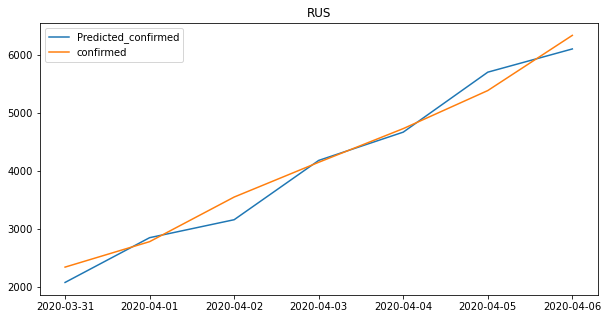

In [17]:
predictions_confirmed = plot_predictions(xgb_confirmed, valid_X_xgb, valid_y, 'confirmed', 'RUS')
predictions_confirmed.round()

**Training best model on the whole dataset**

In [36]:
features = ['density', 'median_age', 'urban_pop_rate',
            'date_first_confirmed', 'prev_day_confirmed',
            'prev_day_deaths']
model_confirmed = xgb_confirmed
model_deaths = xgb_deaths
train_X_all = data_all_2[features]
train_y_all_confirmed = data_all_2[['confirmed']]
train_y_all_deaths = data_all_2[['deaths']]

model_confirmed.fit(train_X_all, train_y_all_confirmed)
model_deaths.fit(train_X_all, train_y_all_deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

**Predict confirmed cases and deaths to the end of the year**

In [57]:
labels = countries.iso_alpha3
dates = pd.date_range("2020-04-07", "2020-05-01")

def predict_nex_day(current_data, countries, features):
    last_date = current_data['date'].max()
    next_date = last_date + pd.to_timedelta(1, unit='d')
    prev_data = current_data[current_data.date == last_date]
    values []
    for country in countries:
        values.append([next_date, country, 0, 0])
    next_data = pd.DataFrame(values, columns = current_data.columns)
    combined_data = current_data.append(next_data)
    next_X = combined_data[features_with_date]
    next_X = next_X[next_X.date == next_date]
    next_data['confirmed'] = model_confirmed.predict(next_X)
    next_data['deaths'] = model_deaths.predict(next_X)
    
    return next_data
    
def predict(data, days):
    predict_data = pd.DataFrame(columns=data.columns)
    for day in days:
        predict_data = predict_data.append(predict_next_day(data.append(predict_data)))
    
    return predict_data.rename(columns={
        'confirmed': 'prediction_confirmed',
        'deaths': 'prediction_deaths'
    })



In [21]:
labels = countries.iso_alpha3
dates = pd.date_range("2020-04-07", "2020-12-31")
predictions_confirmed = []
predictions_deaths = []
pred_data = train_X_all.copy()
data_all_predicted = data_all_2.copy()

for date in dates:
    prediction_confirmed = model_confirmed.predict(pred_data)
    prediction_deaths = model_deaths.predict(pred_data)
    pred_data['prev_day_confirmed'] = prediction_confirmed
    pred_data['date_first_confirmed'] += 1
    pred_data['prev_day_deaths'] = prediction_deaths
    data_all_predicted['confirmed'] = prediction_confirmed
    data_all_predicted['deaths'] = prediction_deaths
    


In [ ]:
"""Creating dataframe with submission"""
submission = pd.DataFrame({
    'date': dates,
    'country': labels,
    'prediction_confirmed': predictions_confirmed,
    'prediction_deaths': predictions_deaths
})
submission

In [27]:
# Proccessing submission
submission = pd.read_csv("./datasets/sample_submission_dDoEbyO.csv")
submission

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-05,AFG,396,7
1,2020-04-06,AFG,449,8
2,2020-04-07,AFG,510,10
3,2020-04-08,AFG,579,11
4,2020-04-09,AFG,658,12
...,...,...,...,...
45794,2020-12-27,ZWE,14862924,148629
45795,2020-12-28,ZWE,14862924,148629
45796,2020-12-29,ZWE,14862924,148629
45797,2020-12-30,ZWE,14862924,148629


In [ ]:
data_recovered = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")